In [6]:
import ssam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [7]:
ds = ssam.SSAMDataset("data/processed/ssam-osmfish")
analysis = ssam.SSAMAnalysis(ds, ncores=40, verbose=True)

Loaded existing KDE results.
Loaded existing local maxima.
Loaded a precomputed normalized vector field.
Loaded existing cluster labels.
Loaded an existing t-SNE result.
Loaded an existing UMAP result.
Loaded existing cell type maps.
Loaded existing filtered cell type maps.
Loaded existing cell type binned centers and counts.
Loaded existing inferred domains.


In [8]:
np.unique(ds.filtered_celltype_maps, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([941723, 108387,  47465,  35216, 108456,  58198,  97768,  51595,
         39904,  34077,  30813,  14956,  13281,  13798,   5037,  12846]))

In [10]:
ds.celltype_binned_counts.shape

(132, 121, 1, 15)

In [11]:
ds.umap.shape

(2787, 2)

In [12]:
ds.celltype_binned_counts[129,0,0,:]

array([1872,    0,   44,    0,  452,    0,    0,  125,    0,    0,   22,
         15,    4,   86,  217])

In [13]:
for i in range(130):
    k = ds.celltype_binned_centers[i,0,:]
    if k != -1:
        print(i, k)

117 [9]
122 [7]
129 [2]


In [14]:
#image -> centers
np.unique(ds.celltype_binned_counts, return_counts=True)

(array([    0,     1,     2, ..., 15488, 15545, 15622]),
 array([84314,  2151,  1954, ...,     1,     1,     1]))

In [15]:
np.squeeze(ds.celltype_binned_counts, 2).shape

(132, 121, 15)

In [16]:
np.squeeze(ds.celltype_binned_centers, 2).shape

(132, 121)

In [17]:
ds.celltype_maps.shape

(1328, 1215, 1)

In [18]:
np.squeeze(ds.celltype_maps+1, 2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
ds.tsne.shape

(2787, 2)

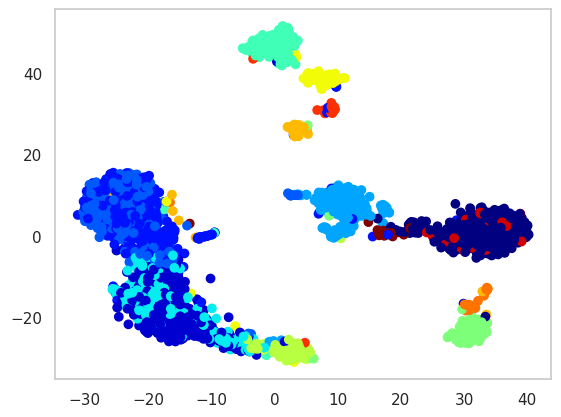

In [20]:
ds.plot_tsne()

In [46]:
np.unique(ds.inferred_domains)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [50]:
#(1328, 1215, 1)
ds.inferred_domains.shape

(1328, 1215, 1)

In [55]:
#770307
len(ds.inferred_domains[ds.inferred_domains != ds.inferred_domains_cells])

770307

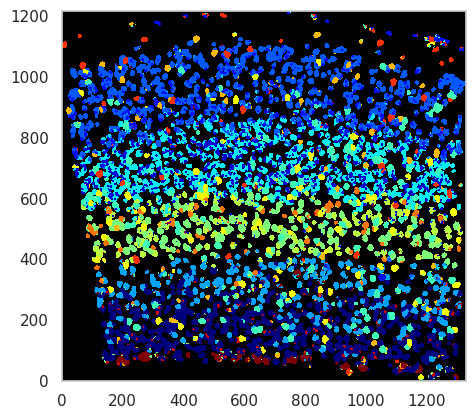

In [28]:
ds.plot_celltypes_map()

In [ ]:
from sklearn.manifold import TSNE
ds.tsne = TSNE(n_iter=n_iter, perplexity=perplexity, early_exaggeration=early_exaggeration, metric=metric, random_state=random_state, **tsne_kwargs).fit_transform(pcs[:, :pca_dims])
ds.zarr_group['tsne'] = ds.tsne

In [ ]:
colors=[], color_excluded="#00000033", cmap="jet"

if ds.filtered_cluster_labels is not None:
    colors = ds.normalized_vectors[ds.filtered_cluster_labels != -1][:, gene_idx]
else:
    colors = ds.normalized_vectors[:, gene_idx]

In [ ]:

        if isinstance(colors, str):
            try:
                gene_idx = list(ds.genes).index(colors)
            except:
                raise ValueError("Not found gene with name %s."%colors)
            if ds.filtered_cluster_labels is not None:
                colors = ds.normalized_vectors[ds.filtered_cluster_labels != -1][:, gene_idx]
            else:
                colors = ds.normalized_vectors[:, gene_idx]
            
        if len(colors) == embedding.shape[0]:
            if not isinstance(colors[0], numbers.Real):
                cmap = None
            plt.scatter(embedding[:, 0], embedding[:, 1], s=s, c=colors, cmap=cmap)
            return
        
        if use_transferred_labels:
            labels = ds.transferred_labels
        else:
            labels = ds.cluster_labels
            
        if ds.filtered_cluster_labels is not None:
            labels = labels[ds.filtered_cluster_labels != -1]
                
        if len(colors) > 0:
            if use_transferred_labels:
                assert len(colors) >= np.max(labels), "Number of colors should be equal or more than the number of transferred labels."
            else:
                assert len(colors) >= len(ds.centroids), "Number of colors should be equal or more than the number of clusters."
            #uniq_labels = np.unique(labels[labels != -1])
            #cmap = ListedColormap([colors[i] for i in uniq_labels])
            colors = np.array(colors)[labels]
        else:
            cmap = plt.get_cmap(cmap)
            colors = plt.get_cmap('jet')(labels / np.max(labels))
            
        if -1 in labels:
            excluded_mask = labels == -1
            if np.sum(excluded_mask) > 0:
                plt.scatter(embedding[:, 0][excluded_mask], embedding[:, 1][excluded_mask], s=s, c=color_excluded)
            plt.scatter(embedding[:, 0][~excluded_mask], embedding[:, 1][~excluded_mask], s=s, c=colors[~excluded_mask])
        else:
            plt.scatter(embedding[:, 0], embedding[:, 1], s=s, c=colors)
    

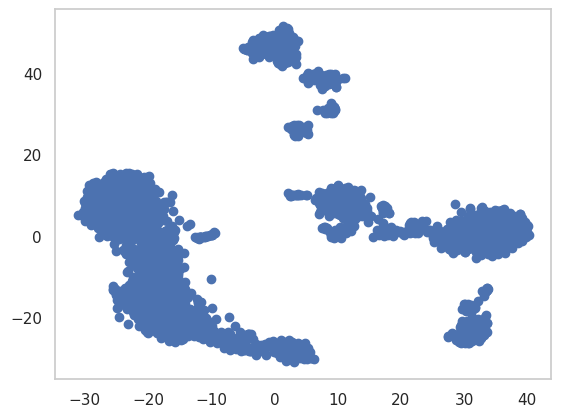

In [15]:
#colors
plt.scatter(ds.tsne[:, 0], ds.tsne[:, 1])

In [26]:
np.unique(ds.cluster_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [43]:
import spatialdata as sd

# ds.celltype_binned_counts had shape (x, y, 1, c), but we need (c, y, x)
celltype_binned_counts = sd.models.Image2DModel.parse(np.squeeze(ds.celltype_binned_counts, 2), dims=('y', 'x', 'c'))

# ds.celltype_binned_centers had shape (x, y, 1), but we need (y, x)
celltype_binned_centers = sd.models.Labels2DModel.parse(np.squeeze(ds.celltype_binned_centers, 2), dims=('y', 'x'))
celltype_maps = sd.models.Labels2DModel.parse(np.squeeze(ds.celltype_maps+1, 2), dims=('y', 'x'))
filtered_celltype_maps = sd.models.Labels2DModel.parse(np.squeeze(ds.filtered_celltype_maps+1, 2), dims=('y', 'x'))
inferred_domains = sd.models.Labels2DModel.parse(np.squeeze(ds.inferred_domains+1, 2), dims=('y', 'x'))
inferred_domains_cells = sd.models.Labels2DModel.parse(np.squeeze(ds.inferred_domains_cells+1, 2), dims=('y', 'x'))

sdata = sd.SpatialData(images={'celltype_binned_counts': celltype_binned_counts},
                       labels={'celltype_binned_centers': celltype_binned_centers, 
                               'celltype_maps': celltype_maps,
                               'filtered_celltype_maps': filtered_celltype_maps, 
                               'inferred_domains': inferred_domains, 
                               'inferred_domains_cells':inferred_domains_cells})

sdata.write('ssam-osmfish-spatialdata.zarr')


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


TypeError: Unsupported type: <class 'xarray.core.dataarray.DataArray'>

In [ ]:
sdata_read = sd.read_zarr('ssam-osmfish-spatialdata.zarr')

print(sdata['celltype_binned_counts'].data)
print(sdata_read['celltype_binned_counts'].data)

from napari_spatialdata import Interactive
Interactive(sdata)